# Exercise 4: **Fourier Analysis, PCA and Clustering**


### Basics of Biomedical Data Analysis

**Stephane Deny**: stephane.deny@aalto.fi

**Carlos Sevilla Salcedo**: carlos.sevillasalcedo@aalto.fi

**Hyunkyung Choo**: hyunkyung.choo@aalto.fi

<br></br>
<center><img src = imgs/pic1.png width="40%">
</center>



In this exercise, we will analyse a biological temporal signal using Fourier analysis, Principal Component Analysis (PCA), and the K-means clustering method.

# 1. Dataset and problem description

The retina sends the visual information to the brain via electric signals, sent through the optic nerve (*Figure 1*). The retinal code is the language with which the retina communicates with the brain. It has been extensively studied by neuroscientists.

In this problem, a rat retina has been placed on a grid of electrode and is being stimulated with a movie. The signals emitted by ganglion cells, the output neurons of the retina, are recorded by the electrodes. The dataset consists of a recording from **one electrode** during **one minute** of movie stimulation. The sampling frequency of the recording is 20,000 Hz.

The ganglion cells emit 'spikes', short electrical impulses conveyed through the optic nerve. Each ganglion cell produces spikes with a unique waveform: you can think of it as an electrical fingerprint which is unique to the cell. One problem we face is that one electrode might record spikes from more than one cell in its surroundings, which makes it difficult to study the cells' responses in isolation.

In this exercise, we will use a high-pass filter to pre-process the temporal trace recorded by the electrode. Next, we will apply principal component analysis and a clustering method to isolate the spikes originating from different cells.


<br></br>
<center>
    <img src=imgs/schematic.png width="60%"><br></br>
<em>Figure 1.</em> <strong>A.</strong> The retina is a neural tissue which covers the interior wall of the eye. The eye lens projects an image of the visual scene onto the retina. <strong>B.</strong> The retina is composed of different layers of neurons: photoreceptors, horizontal cells, biopolar cells, amacrine cells and ganglion cells. The photoreceptors transform the light signals into electrical signals, and the ganglion cells transmit the visual information to the brain via the optic nerve. <strong>C.</strong> Using a grid of electrodes (yellow dots), it is possible to measure the activity of the ganglion cells (visible in green) from an explanted retina in response to diverse visual stimuli.
</center>



## 1.1. Loading the dataset

The data with the electrode activity you will use is stored in `electrode_recording.mat`. The next code cell loads this file containnig the recorded signal for one electrode.

In [1]:
# Importing useful libraries and loading the data
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy import signal
plt.style.use('dark_background')

#change palette
import seaborn as sns
from matplotlib import colors
sns.set(rc={"axes.facecolor":"#FAEBD7" , "figure.facecolor":"#FFEFDB"})

%matplotlib inline

sampling_frequency  = 20000 # in Hz
electrode_activity = np.squeeze(scipy.io.loadmat('electrode_recording.mat')['data'])

print('The recorded signal has %d time points corresponding to %d seconds' %(len(electrode_activity), len(electrode_activity)/sampling_frequency))

The recorded signal has 1200000 time points corresponding to 60 seconds


## 1.2. Data visualisation


We start by visualising the signal corresponding to the first second of recording, showing both the temporal trace and its corresponding spectrogram.

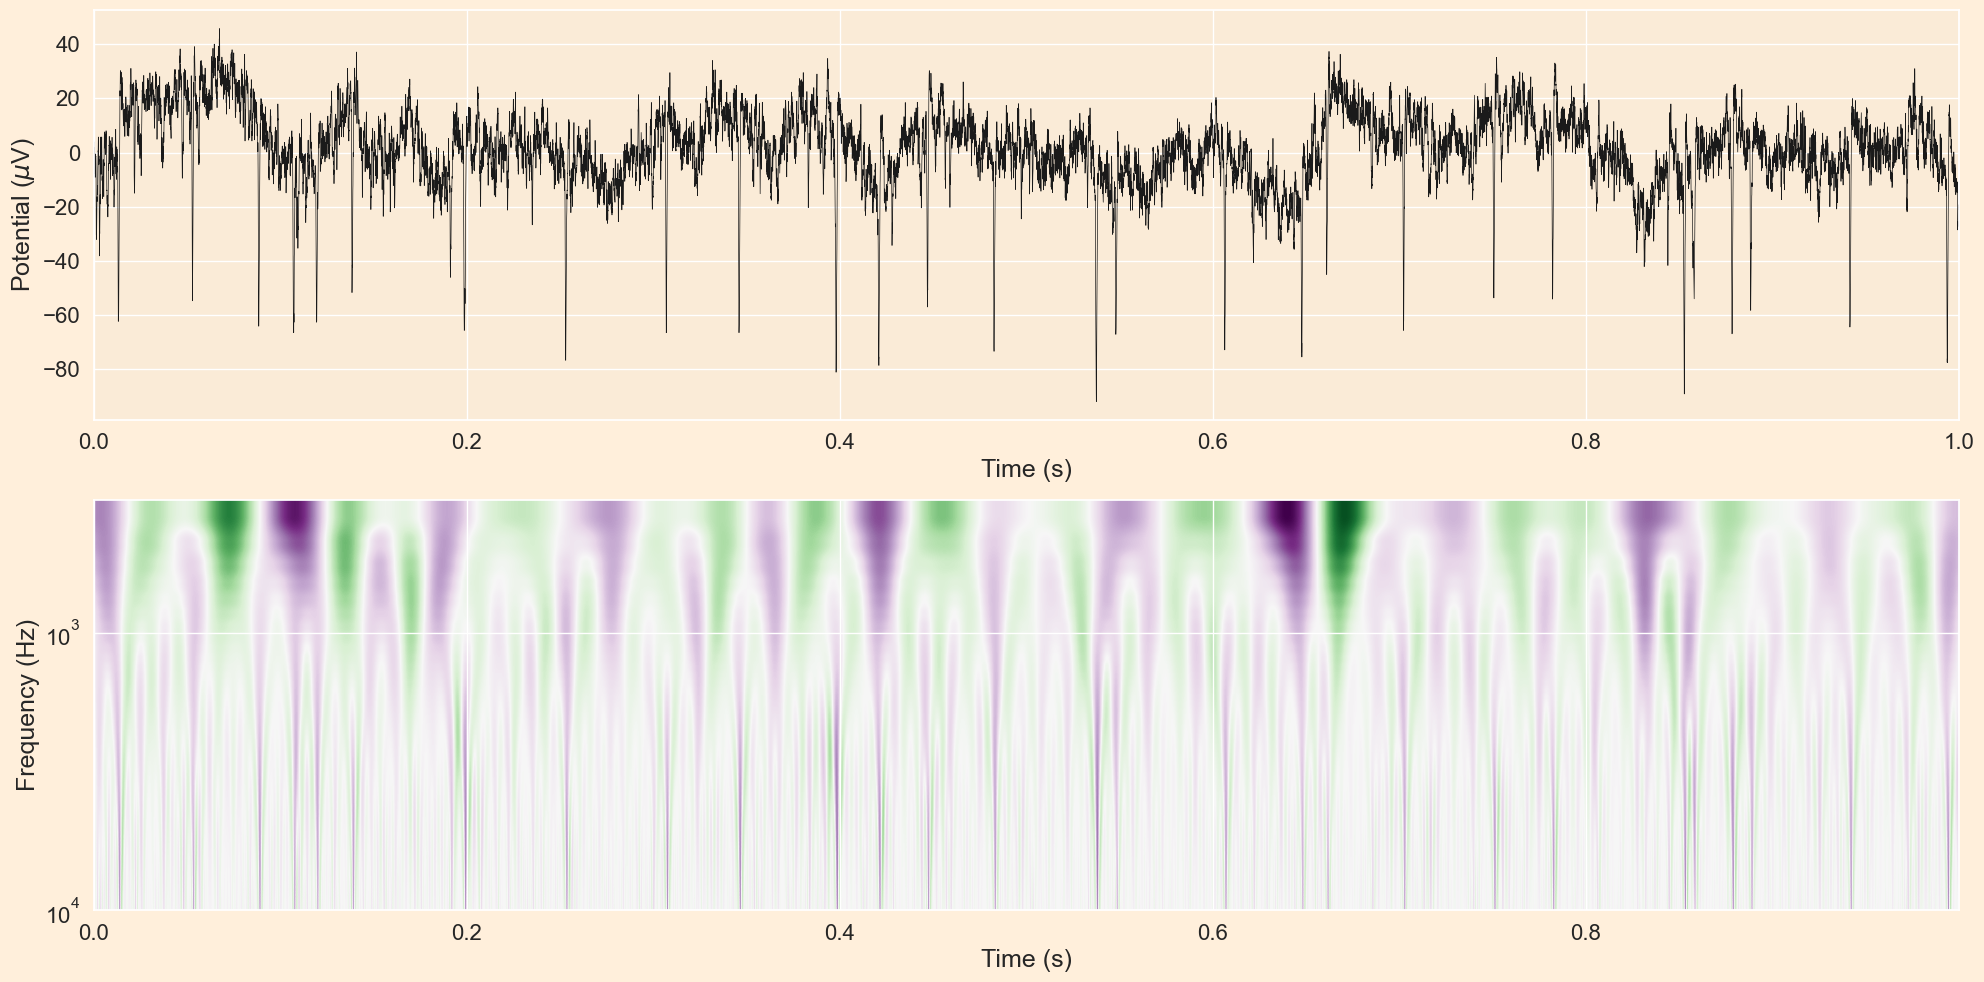

In [2]:
# Plotting one second of the recording and the corresponding spectrogram

Nbins = 1 * sampling_frequency # t (seconds) * sampling frequency (Hz or samples/s) gives us how many samples are in t seconds

fig,axs = plt.subplots(2,1,figsize=(20,10))

# Plotting the temporal trace
time = np.arange(Nbins)/sampling_frequency # x-axis range of values
axs[0].plot(time, electrode_activity[0:Nbins],'k',linewidth=0.5)
axs[0].set_xlim([0,1])
axs[0].set_xlabel('Time (s)', fontsize = 18)
axs[0].set_ylabel('Potential ($\mu$V)', fontsize = 18)
axs[0].tick_params(axis='both', labelsize = 16)

# Computing the spectrogram
widths = 1/np.linspace(1/301,1/10,101)
cwtmatr = signal.cwt(electrode_activity[0:Nbins], signal.ricker, widths)
freqs = 5/widths*sampling_frequency

# Plotting the spectrogram
axs[1].imshow(cwtmatr[:,0:Nbins],extent=[0, time[-1], freqs[-1], freqs[0]], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
axs[1].set_yscale('log')
axs[1].set_ylabel('Frequency (Hz)', fontsize = 18)
axs[1].set_xlabel('Time (s)', fontsize = 18)
axs[1].tick_params(axis='both', labelsize = 16)

plt.tight_layout()

plt.show()

As you can see, this temporal trace has low frequency fluctuations in addition to the spikes. These low frequency fluctuations correspond to the agglomerated activity of all surrounding cells.
> **Question 1**:  By inspecting the spectrogram, can you suggest a good cut-off frequency for a high-pass filter, such that low frequency fluctuations are removed but spikes are conserved?

#YOUR ANSWER HERE

In this context, the high-pass filter would be used to pass frequencies above the chosen cut-off frequency (in this case, 1000 Hz) while removing frequencies below that threshold, since we have low frequencies fluctuation. This can be effective in eliminating low-frequency noise or fluctuations from the signal while retaining the higher-frequency components of interest.

# 2. Preprocessing with a high-pass filter

As we have just seen, there are some low frequency fluctuations present in the recording in addition to the spikes. We would like to remove these low frequency fluctuations with a high-pass filter.

>**Question 2**: Apply a high-pass filter to the temporal trace to remove the low-frequency fluctations. Plot the temporal trace before and after applying the filter, in two separate plots, for the first second of the signal. Add x and y labels and legends to your plots. Time should be in seconds.

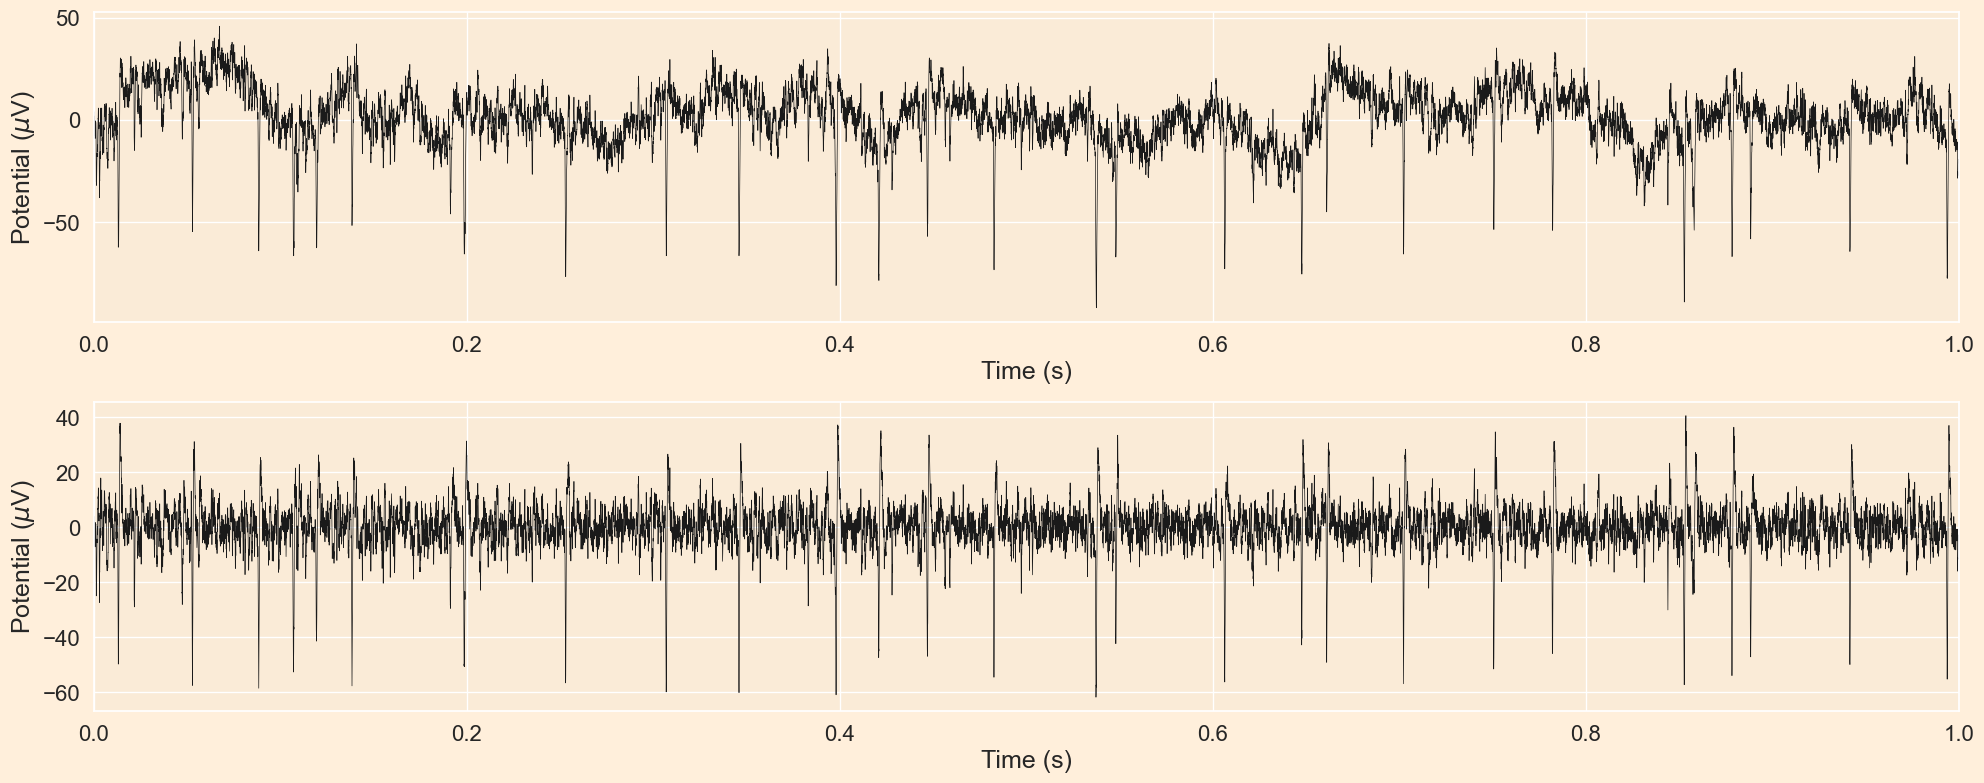

In [3]:
#CODE YOUR SOLUTION HERE

from scipy.signal import lfilter
# info here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html

# Filter the data
cutoff = 1000 # desired cutoff frequency of the filter, Hz
wc = cutoff/sampling_frequency
electrode_activity_filtered = lfilter(np.array([1-wc, wc-1]), np.array([1, wc-1]), electrode_activity)



# Plot both the original and filtered signals in two different subplots.
fig, axs = plt.subplots(2,1,figsize = (20,8))

time = np.arange(Nbins)/sampling_frequency # x-axis range of values
axs[0].plot(time, electrode_activity[0:Nbins],'k',linewidth=0.5)
axs[0].set_xlim([0,1])
axs[0].set_xlabel('Time (s)', fontsize = 18)
axs[0].set_ylabel('Potential ($\mu$V)', fontsize = 18)
axs[0].tick_params(axis='both', labelsize = 16)

Nbin_filtered = 1 * sampling_frequency


# Plotting the temporal trace

time = np.arange(Nbin_filtered)/sampling_frequency# x-axis range of values

axs[1].plot(time, electrode_activity_filtered[0:Nbin_filtered],'k',linewidth=0.5)
axs[1].set_xlim([0,1])
axs[1].set_xlabel('Time (s)', fontsize = 18)
axs[1].set_ylabel('Potential ($\mu$V)', fontsize = 18)
axs[1].tick_params(axis='both', labelsize = 16)

plt.tight_layout()

plt.show()

# 3. Detecting spike times

We will now use a threshold to detect spike times.

> **Question 3**: Find the timespoints corresponding to a spike using a threshold criterion: when the activity crosses a certain threshold, store the corresponding temporal index in an array. Choose the appropriate threshold based on the vizualisations from the previous section.

**Note:** The resulting array should contain all the spike's time indices.

In [4]:
# CODE YOUR SOLUTION HERE

thr = 20 # spike detection threshold in microV
spks, = np.where((electrode_activity_filtered[1:]<thr)*(electrode_activity_filtered[:-1]>thr)) # replace "time" with the correct variable
print('Spikes are in positions:')
print(spks[:50])#I print just a sample
print('Number of spikes:', len(spks))
print('Percentage of spikes:', 100*len(spks)/len(electrode_activity_filtered))

Spikes are in positions:
[  297  1086  1788  1797  2166  2209  2415  2421  2792  2794  2801  3861
  4004  5093  5098  6167  6181  6947  6950  7869  7994  8450  8454  8967
  9680  9684  9687 10782 10987 10989 12162 12977 12980 13250 14073 14809
 15035 15043 15047 15675 16904 17084 17191 17598 17605 18858 18860 18864
 19906 20326]
Number of spikes: 2562
Percentage of spikes: 0.2135


# 4. Spike waveform vizualisation

We are now going to vizualise the waveforms of the detected spikes.

> **Question 3**: Store all the spike waveforms into a matrix: for each spike, select a window of 51 time bins centered on the spike time, and store the corresponding waveform in matrix `waveforms`. Plot all the waveforms on top of each other.

**Note:** Matrix `waveform` should be of size $number\_of\_spikes \times 51$.

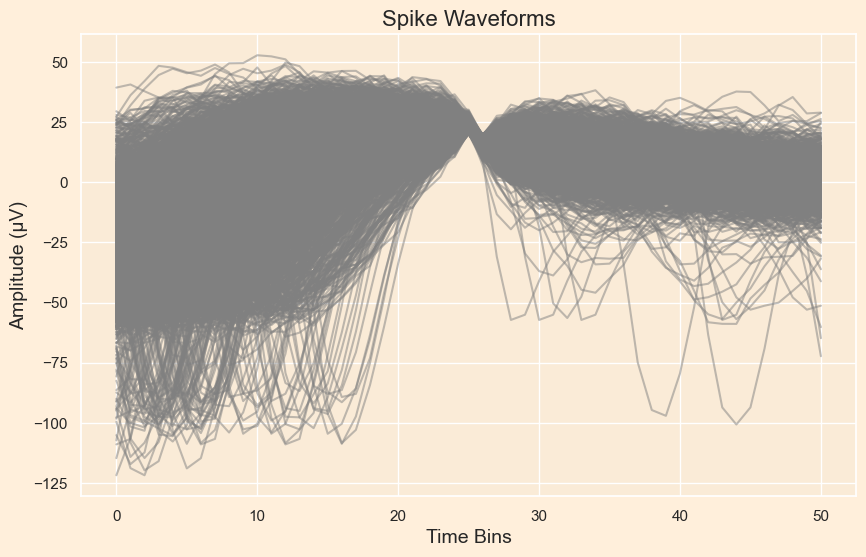

In [5]:
# Define the size of the window around each spike
window_size = 51

# Create an empty matrix to store spike waveforms
waveforms = np.empty((len(spks), window_size))

# Iterate through the spike time indices
for i, spike_index in enumerate(spks):
    # Calculate the start and end indices for the window around the spike
    start_index = spike_index - window_size // 2
    end_index = spike_index + window_size // 2
    
    # Extract the waveform and store it in the waveforms matrix
    if start_index >= 0 and end_index < len(electrode_activity_filtered):
        waveform = electrode_activity_filtered[start_index:end_index + 1]
        waveforms[i, :] = waveform

# Plot all the waveforms on top of each other
plt.figure(figsize=(10, 6))
plt.plot(waveforms.T, color='gray', alpha=0.5)
plt.xlabel('Time Bins', fontsize=14)
plt.ylabel('Amplitude (μV)', fontsize=14)
plt.title('Spike Waveforms', fontsize=16)
plt.show()

> **Question 4**: Can you visually identify different waveforms which could correspond to different cells?

#YOUR ANSWER HERE

Regarding the amplitudes, it is noticeable that for time bins beyond 25, a prevailing pattern emerges: most waveforms exhibit a uniform amplitude. This consistent amplitude trend might suggest the potential presence of a specific cell type or a sustained neural activity pattern during this time interval. This observation holds significance and should prompt further exploration and in-depth analysis.

Furthermore, when examining time bins before 25, we still observe a certain common trend, albeit with notable exceptions where certain waveforms exhibit amplitudes significantly divergent from the rest.

Furthermore, when considering time bins before 25, it becomes evident that these divergent waveforms not only have significantly different amplitudes but also possess a shape that markedly deviates from the typical waveform pattern observed in others.

# 5. Spike waveform vizualisation in PCA space

We are now going to vizualise the waveforms in a low dimensional space. We will use PCA to identify a low dimensional space preserving most of the variance of the data. We will then represent waveforms projected onto the two principal components of PCA.

> **Question 5**: Use PCA to vizualise the waveforms in a lower dimensional space. To do so:
>  1. Compute the covariance matrix of the waveform matrix. The covariance matrix should have size `51`x`51`. Plot this covariance matrix using `imshow`.
>  2. Apply PCA to this covariance matrix (you can use [np.linalg.eig](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html)).
>  3. Sort the eigenvalues in descending order and plot them (you can use [np.sort](https://numpy.org/doc/stable/reference/generated/numpy.sort.html)).
>  4. Plot the eigenvectors corresponding to the two first eigenvalues.
>  5. Project the waveform data onto these two first eigenvectors, and plot the resulting projections in a 2D scatter plot (each point corresponds to one waveform, x-axis is PC1 and y-axis is PC2).


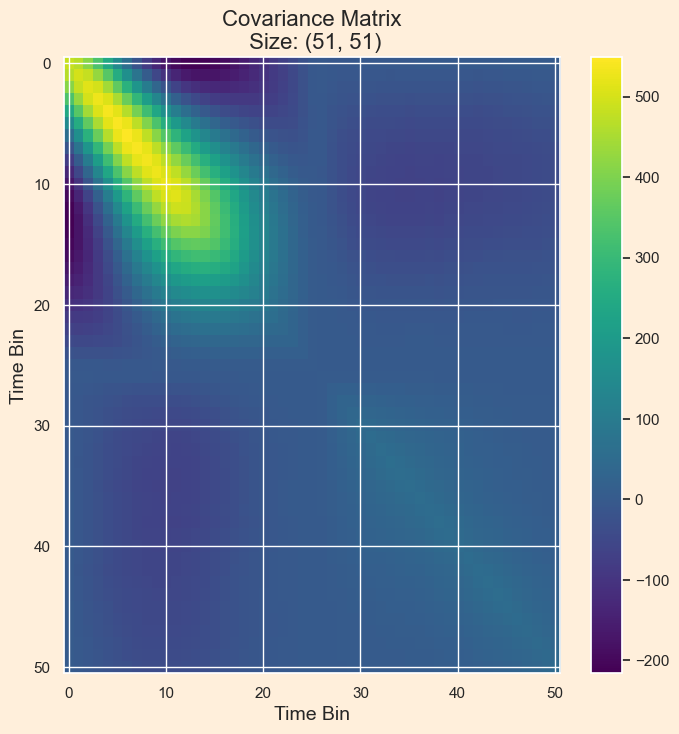

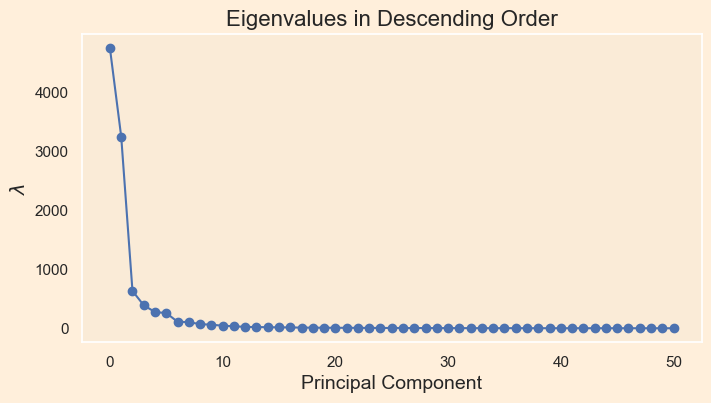

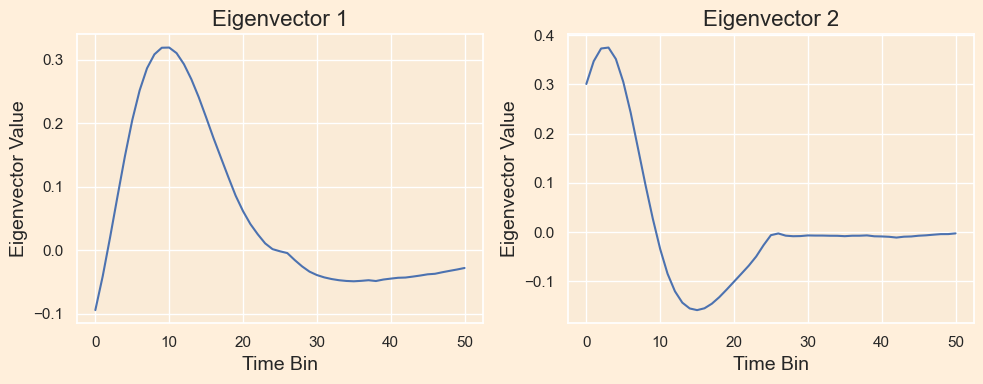

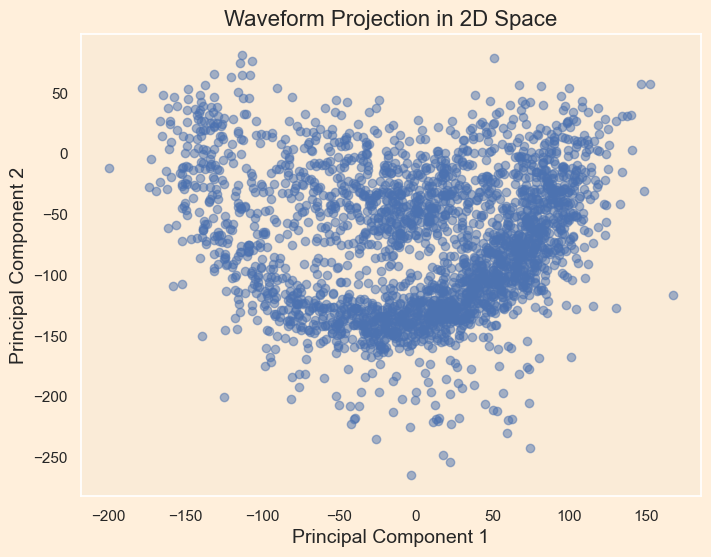

In [6]:
# CODE YOUR SOLUTION HERE

# Step 1: Compute the covariance matrix, and plot it
covariance_matrix = np.cov(waveforms, rowvar=False)

#plot covariance matrix
plt.figure(figsize=(8, 8))
plt.imshow(covariance_matrix, cmap='viridis', origin='upper', aspect='auto')
plt.colorbar()
plt.title(f'Covariance Matrix\n Size: {covariance_matrix.shape}', fontsize=16)
plt.xlabel('Time Bin', fontsize=14)
plt.ylabel('Time Bin', fontsize=14)
plt.show()

# Step 2: Apply PCA to the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

# Step 3: Sort the eigenvalues in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]


plt.figure(figsize=(8, 4))
plt.plot(eigenvalues, marker='o', linestyle='-')
plt.xlabel('Principal Component', fontsize=14)
plt.ylabel(r'$\lambda$', fontsize=14)
plt.title('Eigenvalues in Descending Order', fontsize=16)
plt.grid()
plt.show()

# Step 4: Plot the eigenvectors corresponding to the two largest eigenvalues
eigenvectors=eigenvectors[:,sorted_indices]#I'll sort also eigenvectors
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(eigenvectors[:,0])
plt.xlabel('Time Bin', fontsize=14)
plt.ylabel('Eigenvector Value', fontsize=14)
plt.title('Eigenvector 1', fontsize=16)

plt.subplot(122)
plt.plot(eigenvectors[:,1])
plt.xlabel('Time Bin', fontsize=14)
plt.ylabel('Eigenvector Value', fontsize=14)
plt.title('Eigenvector 2', fontsize=16)
plt.tight_layout()
plt.show()

# Step 5: Project the waveform data onto the two first eigenvectors
projection = np.dot(waveforms, eigenvectors[:, sorted_indices[:2]])

# Step 7: Create a 2D scatter plot of the projected data
plt.figure(figsize=(8, 6))
plt.scatter(projection[:, 0], projection[:, 1], c='b', marker='o', alpha=0.5)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.title('Waveform Projection in 2D Space', fontsize=16)
plt.grid()
plt.show()

>  **Question 6**: By inspecting this scatter plot, do you find well-defined clusters? Does this suggest that this electrode is recording from more than one cell?

#YOUR ANSWER HERE

We can observe a clear crescent-shaped pattern; however, it is not very evident whether there are three distinct clusters. One cluster appears to occupy the central region, while the other, as previously mentioned, resembles a crescent shape. This suggests that there might be two distinct clusters or groups of data points, possibly indicating that the electrode is recording from more than one cell. Additionally we can see a certain simmetry.

# 6. Isolating the different cells with K-means
In order to isolate the different types of waveforms, we will cluster the waveforms using K-means.

> **Question 7**: Apply K-means clustering to the waveform matrix. Try `K = 2` and `K = 3`.
> 1. For each number of clusters K, repeat the plot from question 3, representing all the waveforms on top of each other, using a different color for each subset of waveforms corresponding to a different cluster.
> 2. For each number of cluster K, repeat the last plot from question 5, the scatterplot of waveforms projected in principal component space, using a different color for each subset of points corresponding to a different cluster.


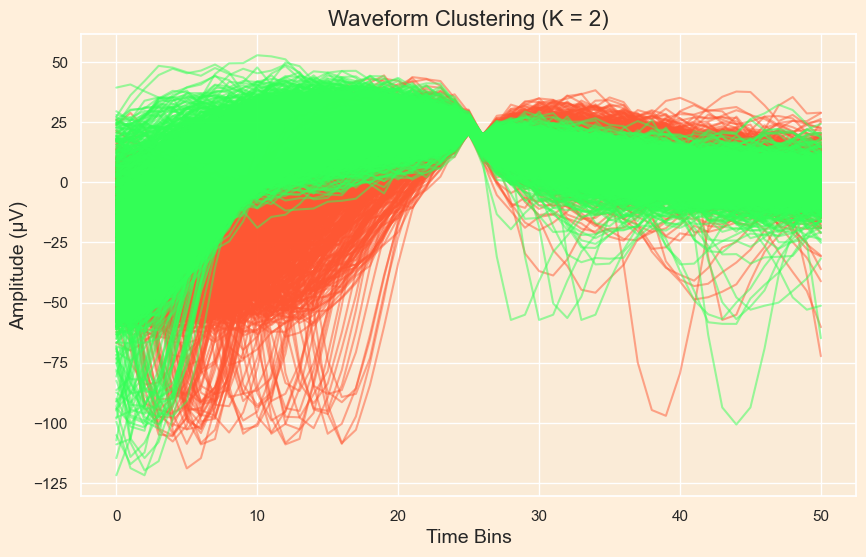

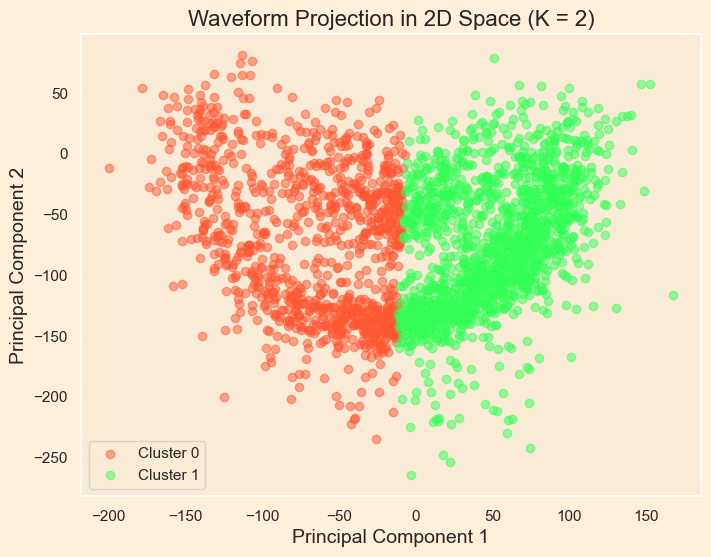

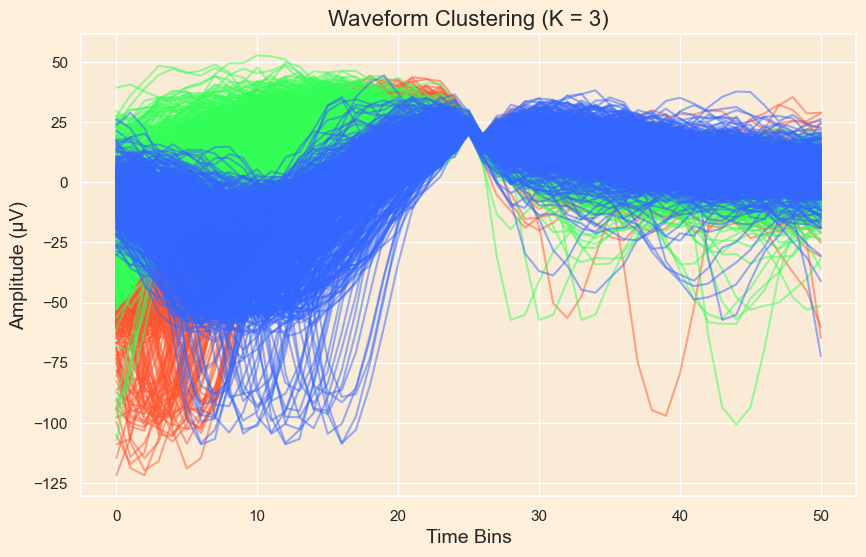

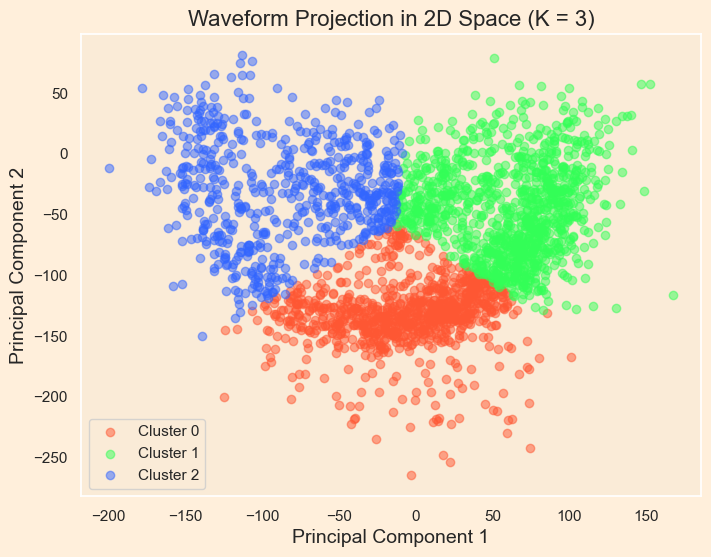

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Specify the values of K (number of clusters)
K_values = [2, 3]

colors = ["#FF5733", "#33FF57", "#3366FF", "#FF33E6", "#FFFF33"]

# Iterate through different values of K
for K in K_values:
    # Apply K-means clustering with n_init explicitly set to suppress the warning
    kmeans = KMeans(n_clusters=K, random_state=0, n_init=10)
    labels = kmeans.fit_predict(waveforms)

    # Plot all the waveforms on top of each other with different colors
    plt.figure(figsize=(10, 6))
    
    for i in range(K):
        plt.plot(waveforms[labels == i].T, color=colors[i], alpha=0.5)
    plt.xlabel('Time Bins', fontsize=14)
    plt.ylabel('Amplitude (μV)', fontsize=14)
    plt.title(f'Waveform Clustering (K = {K})', fontsize=16)
    plt.show()

    # Project the waveform data onto the two first eigenvectors
    projection = np.dot(waveforms, eigenvectors[:, sorted_indices[:2]])

    # Create a scatter plot of the projected data with different colors for clusters
    plt.figure(figsize=(8, 6))
    for i in range(K):
        plt.scatter(
            projection[labels == i, 0],
            projection[labels == i, 1],
            c=[colors[i]],
            marker='o',
            alpha=0.5,
            label=f'Cluster {i}'
        )
    plt.xlabel('Principal Component 1', fontsize=14)
    plt.ylabel('Principal Component 2', fontsize=14)
    plt.title(f'Waveform Projection in 2D Space (K = {K})', fontsize=16)
    plt.legend()
    plt.grid()
    plt.show()

> **Question 8**: By visually inspecting the results of K-means in PC space and waveform space, can you decide how many different cells this electrode is recording from. What is your level of certainty?

#YOUR ANSWER HERE

Upon inspecting K-means clustering in the principal component (PC) space, both clusters appear to be reasonable, with the K=3 cluster showing a higher cohesion among its clusters. However, in the waveform space, it seems that both clusters capture the data trends accurately. Interestingly, the K=2 cluster appears to separate the waveforms more effectively.

Nevertheless, it's worth noting that both clusters 'destroy' the crescent moon shape and the central globular accumulation. Given these observations, it may be beneficial to compare the results with a DBSCAN clustering approach for a more comprehensive analysis.